# Visualizing and measuring interface area in fluid/fluid displacement

**Authors:** Drs. Masa Prodanovic and Bernard Chang

**Updated:** May 2025


## Objective

In this hands-on exercise, we will measure interfacial areas from imaged multi-phase fluid configurations obtained during main drainage in glass beads.

## Introduction

Interfacial area consists of the area between fluid interfaces, and plays an important role in various transformation processes (liquid-liquid phase dissolution, solid-liquid phase precipitation/dissolution, vapor extraction etc.). The interfacial areas are also highly influential when it comes to the pressure state of the system. 

The right-hand figure below shows how mass transfer during dissolution of an oily contaminant (NAPL – non-aqueous phase liquid) in groundwater (or during an engineering process in a porous medium) affects the mass transfer rate. 

<img src="_static/fig1.png" width="50%"/>

For this project, we are interested in measuring the area between the NAPL (NW, non-wetting) and water (W, wetting) phases. We are particularly keen on establishing the relationships between water saturation and fluid-fluid interfacial area, as well as water saturation and solid-fluid area, so the end result will be plots of these relationships.

You will need to process the data to the point where you can measure these variables, so the data needs to be aligned (registered), filtered, segmented, processed to determine saturation levels, surfaces generated for area measurement, and plots generated. Because you will be working with multiple data sets, you may want to also develop a macro to do this. 


In [ ]:
# Uncomment the following line to install dependencies locally
# !pip install -r requirements.txt

import dpm_tools as dpm

# Some Utility functions
from pathlib import Path

# Image processsing
import skimage

# Image visualization
import pyvista as pv

import matplotlib.pyplot as plt

# Image quantification
import numpy as np

[15:29:34] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=190243;file://C:\Users\bcc2459\AppData\Roaming\Python\Python312\site-packages\openpnm\utils\_workspace.py\_workspace.py]8;;\:]8;id=22251;file://C:\Users\bcc2459\AppData\Roaming\Python\Python312\site-packages\openpnm\utils\_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

## Read data and resize

The data we are working with are imaged multi-phase fluid configurations obtained during main drainage in glass beads. Each image has resolution of $13$ micron.

More information about the main drainage data used here can be found in [Porter et al. (2010)](https://doi.org/10.1029/2009wr007786) [<a href="#ref-1">1</a>]

(425, 550, 555)
Original image statistics

-----------------------------------
Image statistics:
	Shape: (425, 550, 555)
	Data type: uint8
	Min: 0, Max:               255, Mean: 197.5810675685311

-----------------------------------
Image statistics:
	Shape: (415, 380, 380)
	Data type: uint8
	Min: 0, Max:               255, Mean: 184.83697728865602



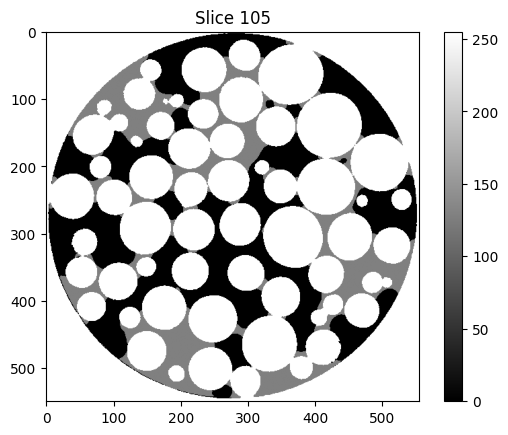

<Figure size 640x480 with 0 Axes>

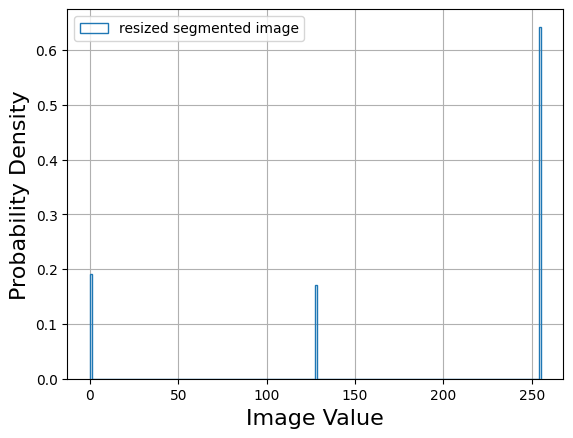

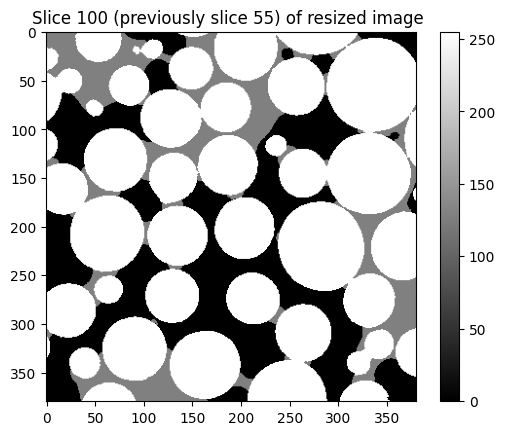

In [12]:
fname = Path('./segmented/MD_07.tif')
img = dpm.io.read_image(fname)
print(img.shape)

print('Original image statistics\n')
dpm.metrics.histogram_statistics(img, plot_histogram=False)

plt.imshow(img[105,:,:], cmap='gray')
plt.title('Slice 105')
plt.colorbar()


# Take a subset, 415 slices in z, and 380 in x and y directions
img_sub = img[5:420,85:465,85:465]
plt.figure()
dpm.metrics.histogram_statistics(img_sub, plot_histogram=True,legend_elem=['resized segmented image'])

plt.figure()
plt.imshow(img_sub[100,:,:], cmap='gray')
plt.title('Slice 100 (previously slice 55) of resized image ')
plt.colorbar()


## Define Utility Functions

### Plot isosurfaces

The specialized ``plot_isosurfaces()`` function defined below uses the PyVista wrapper function in DPM Tools to visualize the isosurfaces of the given phases. Both solid and wetting phases are padded to close the surfaces along the volume edge for visualization purposes. 

You can try modifying the keyword argument dictionaries listed in the ``dpm.visualization.plot_isosurface()`` function to customize the appearance of the isosurfaces.

In [3]:
def plot_isosurfaces(image, phase1, phase2):
    # pv.start_xvfb()
    plotter_obj = pv.Plotter(lighting='three lights')

    # Set background colors
    plotter_obj.set_background(color='w')

    # Set font colors and sizes
    pv.global_theme.font.color = 'black'
    pv.global_theme.font.size = 18
    pv.global_theme.font.label_size = 14
    
    pv.set_jupyter_backend('html')
    
    #sample = (image==phase1).astype(np.int8)
    sample = image == phase1
    sample = np.pad(sample, ((1, 1), (1, 1), (1, 1)), mode='constant', constant_values=0)
    sample = dpm.io.Image(scalar=sample)
    
    plotter_obj = dpm.visualization.plot_isosurface(sample, plotter_obj, show_isosurface=[0.5], 
                    mesh_kwargs={"opacity":0.5, 
                                "color":(200 / 255, 181 / 255, 152 / 255), 
                                "diffuse": 0.75, 
                                "ambient": 0.15,
                                "smooth_shading":True}, smooth_kwargs={"n_iter": 50})
    
    sample = image == phase2
    sample = np.pad(sample, ((1, 1), (1, 1), (1, 1)), mode='constant', constant_values=0)
    sample = dpm.io.Image(scalar=sample)
    plotter_obj = dpm.visualization.plot_isosurface(sample, plotter_obj, show_isosurface=[0.5], 
                    mesh_kwargs={"opacity":1, 
                                "color":(80 / 255, 80 / 255, 152 / 255), 
                                "diffuse": 0.75, 
                                "ambient": 0.15}, smooth_kwargs={"n_iter": 50}) 

    
    plotter_obj.show(jupyter_backend='html')

In [ ]:
# Note: the first and last slice have segmentation noise (likely due to being on the volume edge)
# We will resize to also get away from the cylinder volume edges

# plotting 100^3 subset
plot_isosurfaces(img_sub[100:200,100:200,100:200], 255, 128)

# plot_isosurfaces(img_sub, 255,128)

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

### Compute Interfacial Areas

Surface areas can be computed using two methods:

1. Counting arrangements of $2^3$ neighborhoods of voxels (DPM Tools)
2. Using a mesh representation of the interface (Scikit-Image)

Once the surface areas of each phase are computed, the following equations can be used to establish the interfacial area between NW and W phase, assuming presence of solid (S) phase:

$$ SA_{NW-W} = \frac{1}{2}(SA_{NW} + SA_{W} - SA_{S}), $$

Other interfacial area (NW-S, W-S) have analogous formulas.

Both the voxel counting approach and the original marching cubes algorithm (used for generating meshes) calculates interfacial areas strictly between two phases. When using the algorithm to calculate surface area of NW phase, we isolate NW phase from the rest (create a new image). 

In [32]:
def compute_surface_area(image, smoothing=None):

    # DPM Tools
    _, dpm_surface_area, _, dpm_euler_number = dpm.metrics.minkowski_functionals(image, pad=False)
    
    # Mesh Surface Area
    # Gaussian filtering changes area calculation a lot
    # image = skimage.filters.gaussian(image)
    verts, faces, normals, values = skimage.measure.marching_cubes(image, level=smoothing)
    mesh_surface_area = skimage.measure.mesh_surface_area(verts, faces)
    # 26-connected
    mesh_euler_number_26c = skimage.measure.euler_number(image, connectivity=3)
    # 6-connected
    mesh_euler_number_6c = skimage.measure.euler_number(image, connectivity=1)
    # Take the average of 6-connected and 26-connected
    mesh_euler_number = (mesh_euler_number_26c + mesh_euler_number_6c)/2
    
    return np.array([dpm_surface_area, mesh_surface_area]), np.array([dpm_euler_number, mesh_euler_number])

def compute_interfacial_areas(img_sub, dx=1):
    # TODO: Replace with minkowski_functionals & report W and NW Euler number
    A_s, X_s = compute_surface_area(img_sub==255, 0.5)
    A_nw, X_nw = compute_surface_area(img_sub==0, 0.5)
    A_w, X_w = compute_surface_area(img_sub==128, 0.5)
    
    #print("Anw= ",A_nw,"\n  Aw=",A_w,"\n  As=",A_s)
    # compute interfacial areas
    A_nw_w = 0.5 * (A_nw + A_w - A_s)
    A_w_s  = 0.5 * (A_w + A_s - A_nw)
    A_nw_s = 0.5 * (A_nw + A_s - A_w)
    dA = dx*dx  # in mm^2


    print(f'NW-W area: {A_nw_w * dA} mm^2')
    
    
    V_nw = np.sum(img_sub==0)
    V_w = np.sum(img_sub==128)
    V_s = np.sum(img_sub==255)

    total_volume = V_s + V_nw + V_w

    A_nw_w_per_vol = A_nw_w / (total_volume * dx)
    A_w_s_per_vol = A_w_s / (total_volume * dx)
    A_nw_s_per_vol = A_nw_s / (total_volume * dx)
    
    S_w = V_w / (V_nw + V_w)
    
    print(f'Sw= {S_w}')
    print(f'NW-W area per volume: {A_nw_w_per_vol} mm^(-1)')
    print(f'NW-W area per volume: {A_nw_w_per_vol} mm^(-1)')
   
    return S_w, A_nw_w_per_vol, A_w_s_per_vol, A_nw_s_per_vol, X_w, X_nw

def read_image_compute_areas(fname):
    
    img = dpm.io.read_image(fname)

    img_sub = img[5:420,85:465,85:465]
    S_w, A_nw_w_per_vol, A_w_s_per_vol, A_nw_s_per_vol, X_w, X_nw = compute_interfacial_areas(img_sub, 0.013)
   
    return S_w, A_nw_w_per_vol, A_w_s_per_vol, A_nw_s_per_vol, X_w, X_nw

./segmented/MD_01.tif
NW-W area: [14.44234567 15.70944253] mm^2
Sw= 0.9130812414920567
NW-W area per volume: [0.1096964 0.1193206] mm^(-1)
NW-W area per volume: [0.1096964 0.1193206] mm^(-1)
./segmented/MD_02.tif
NW-W area: [14.64049817 15.92135797] mm^2
Sw= 0.9120589332796577
NW-W area per volume: [0.11120146 0.1209302 ] mm^(-1)
NW-W area per volume: [0.11120146 0.1209302 ] mm^(-1)
./segmented/MD_05.tif
NW-W area: [44.39365233 48.29385194] mm^2
Sw= 0.6345803581831099
NW-W area per volume: [0.33719065 0.3668145 ] mm^(-1)
NW-W area per volume: [0.33719065 0.3668145 ] mm^(-1)
./segmented/MD_07.tif
NW-W area: [54.083718   58.26107056] mm^2
Sw= 0.4704754302989677
NW-W area per volume: [0.41079126 0.44252021] mm^(-1)
NW-W area per volume: [0.41079126 0.44252021] mm^(-1)
./segmented/MD_09.tif
NW-W area: [60.57182517 65.19409487] mm^2
Sw= 0.3730215419908188
NW-W area per volume: [0.46007148 0.49517979] mm^(-1)
NW-W area per volume: [0.46007148 0.49517979] mm^(-1)
./segmented/MD_10.tif
NW-W ar

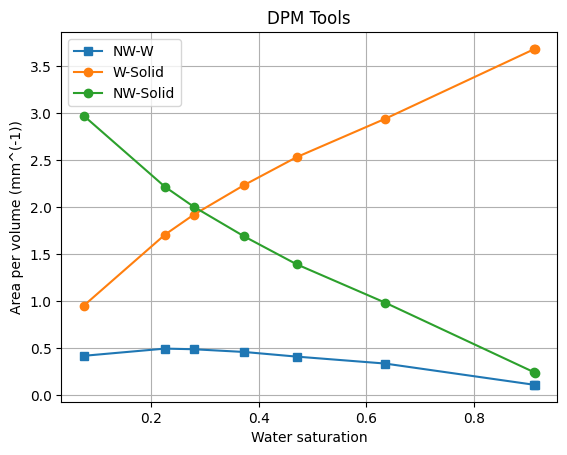

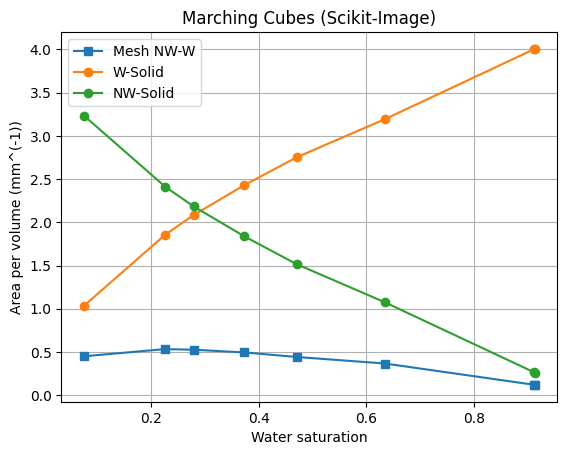

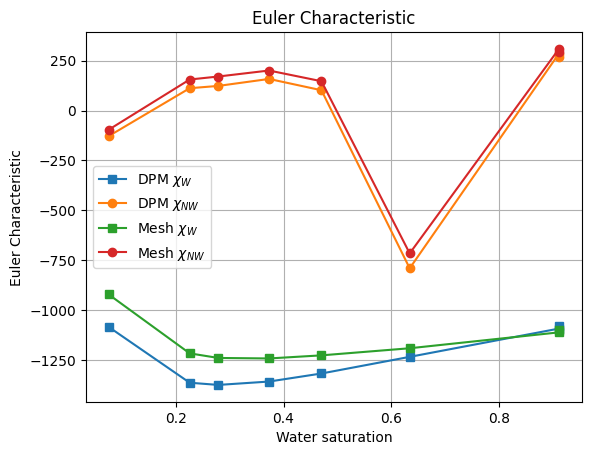

In [ ]:
file_ids = [1, 2, 5, 7, 9, 10, 11, 12]
n = len(file_ids)
S_w = np.zeros((n, 2))
A_nw_w_per_vol = np.zeros((n, 2))
A_w_s_per_vol = np.zeros((n, 2))
A_nw_s_per_vol = np.zeros((n, 2))
X_w = np.zeros((n, 2))
X_nw = np.zeros((n, 2))

for j in range(n):
    i= file_ids[j]
    fname = f'./segmented/MD_{i:02}.tif' 
    print(fname)
    S_w[j], A_nw_w_per_vol[j], A_w_s_per_vol[j], A_nw_s_per_vol[j], X_w[j], X_nw[j] = read_image_compute_areas(fname)
   
# DPM Tools Result
plt.figure()
plt.plot(S_w[:, 0], A_nw_w_per_vol[:, 0],'s-',label='NW-W')
plt.plot(S_w[:, 0], A_w_s_per_vol[:, 0],'o-',label='W-Solid')
plt.plot(S_w[:, 0], A_nw_s_per_vol[:, 0],'o-',label='NW-Solid')
plt.legend()
plt.title('DPM Tools')
plt.xlabel('Water saturation')
plt.ylabel('Area per volume (mm^(-1))')
plt.grid(True)

# Marching Cubes Result
plt.figure()
plt.plot(S_w[:, 1], A_nw_w_per_vol[:, 1],'s-',label='Mesh NW-W')
plt.plot(S_w[:, 1], A_w_s_per_vol[:, 1],'o-',label='W-Solid')
plt.plot(S_w[:, 1], A_nw_s_per_vol[:, 1],'o-',label='NW-Solid')
plt.legend()
plt.title('Marching Cubes (Scikit-Image)')
plt.xlabel('Water saturation')
plt.ylabel('Area per volume (mm^(-1))')
plt.grid(True)

# Euler Characteristic
plt.figure()
plt.plot(S_w[:, 1], X_w[:, 0],'s-',label='DPM $\chi_W$')
plt.plot(S_w[:, 1], X_nw[:, 0],'s-',label='DPM $\chi_{NW}$')
plt.plot(S_w[:, 1], X_w[:, 1],'o-',label='Mesh $\chi_W$')
plt.plot(S_w[:, 1], X_nw[:, 1],'o-',label='Mesh $\chi_{NW}$')
plt.legend()
plt.title('Euler Characteristic')
plt.xlabel('Water saturation')
plt.ylabel('Euler Characteristic')
plt.grid(True)


## References

<a id="ref-1"></a>  
[1] Porter, Mark L., Dorthe Wildenschild, Gavin Grant, and Jason I. Gerhard. 2010. “Measurement and Prediction of the Relationship between Capillary Pressure, Saturation, and Interfacial Area in a NAPL‐water‐glass Bead System.” Water Resources Research 46 (8). https://doi.org/10.1029/2009wr007786.


